# Seed to alignment pipeline in individual steps

Overall, seed-to-alignment takes a seed dataframe (see documentation or *01_seed_to_alignment.ipynb*), BLASTs to find sequence hits, performs quality control, lowers alignment redundancy in a taxonomically informed fashion, and generates an alignment.

This notebook offers users the option to make step-specific manipulations of parameters fed into the seed-to-alignment pipeline. There is a walk-through of these steps using a toy dataset included in the topiary package at the end of this notebook. See *01_seed_to_alignment.ipynb* to initiate the entire pipeline with one code block.

<a href="https://githubtocolab.com/harmslab/topiary-examples/blob/main/notebooks/02_seed_to_alignment_step_wise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Setup
Start by running the cells below to set up topiary and all required software. Re-initialize your environment before re-running subsequent code blocks to make sure you are in the correct directory.

In [ ]:
### THIS CELL SETS UP TOPIARY IN A GOOGLE COLAB ENVIRONMENT. 
### IF RUNNING THIS NOTEBOOK LOCALLY, IT MAY BE SAFELY DELETED.

#@title Install software

#@markdown #### Installation requires two steps.

#@markdown 1. Install the software by pressing the _Play_ button on the left.
#@markdown Please be patient. This will take several minutes. <font color='teal'>
#@markdown After the  installation is complete, the kernel will reboot 
#@markdown and Colab will complain that the session crashed. This is normal.</font>
#@markdown <br/>
#@markdown 2. After this cell runs, run the "Initialize environment" cell that follows.

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:

    import os
    os.chdir("/content/")

    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/harmslab/topiary-examples/main/notebooks/colab_installer.py",
                              "colab_installer.py")

    import colab_installer
    colab_installer.install_topiary(install_raxml=False,
                                    install_generax=False)

In [ ]:
### IF RUNNING LOCALLY, ACTIVATE THE TOPIARY ENVIRONMENT IN CONDA
### AND RE-OPEN THIS NOTEBOOK.

import topiary
import numpy as np
import pandas as pd 

### EVERYTHING AFTER THIS LINE IS IS USED TO SET UP TOPIARY IN A GOOGLE
### COLAB ENVIRONMENT. IF RUNNING THIS NOTEBOOK LOCALLY, THE LINES BELOW
### IN THIS CELL MAY BE SAFELY DELETED. 

#@title Initialize environment

#@markdown  Run this cell to initialize the environment after installation.
#@markdown (This cell can also be run if the kernel dies during a calculation,
#@markdown allowing you to reload modules without having to
#@markdown reinstall.) Re-run this cell if you have to re-run any subsequent
#@markdown cells so that your calculations are in the correct directory.

#@markdown We recommend setting up a working directory on your google drive. This is a 
#@markdown convenient way to pass files to topiary and will allow you to save
#@markdown your work. For example, if you type `topiary_work` into the form
#@markdown field below, topiary will save all of its calculations in the 
#@markdown `topiary_work` directory in MyDrive (i.e. the top directory at
#@markdown https://drive.google.com). This script will create the directory if 
#@markdown it does not already exist. If the directory already exists, any files
#@markdown that are already in that directory will be available to topiary. You could, 
#@markdown for example, put a file called `seed.csv` in `topiary_work` and then
#@markdown access it as "seed.csv" in all cells below.
#@markdown <br/><br/>
#@markdown Note: Google may prompt you for permission to access the drive. 
#@markdown To work in a temporary colab environment, leave this blank. 

# Select a working directory on google drive
google_drive_directory = "" #@param {type:"string"}

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:

    import os
    os.chdir("/content/")

    topiary._in_notebook = "colab"
    import colab_installer
    colab_installer.initialize_environment()
    colab_installer.mount_google_drive(google_drive_directory)

In [ ]:
#@title Load seed dataset

#@markdown Before running this cell, specify either: 
#@markdown + A file containing a seed dataset in your working
#@markdown directory (your google drive specified above).
#@markdown The default input file is an example LY86/LY96 seed dataset.
#@markdown + Select `upload_file` to upload a file directly from your computer. 

seed_dataset = "https://raw.githubusercontent.com/harmslab/topiary-examples/main/data/ly86-ly96.csv" #@param {type:"string"}
upload_file = False   #@param {type:"boolean"}

#@markdown Your file will be loaded into a pandas dataframe called `seed_df`

if issubclass(type(seed_dataset),str):
    seed_dataset = seed_dataset.strip()

if seed_dataset != "" and upload_file:
    err = "Please give a seed_dataset OR select upload file\n"
    raise ValueError(err)
  
if seed_dataset == "" and not upload_file:
    err = "Please either give a seed_dataset or select upload file\n"
    raise ValueError(err)

if upload_file:

    try:
        from google.colab import files
        uploaded_files = files.upload()
        keys = list(uploaded_files.keys())
        seed_dataset = keys[0] #uploaded_files[keys[0]]
    except ImportError:
        pass
    
try:
    seed_df = pd.read_csv(seed_dataset)
except:
    try:
        seed_df = pd.read_excel(seed_dataset)
    except:
        err = f"Could not read {seed_dataset}. This should be a csv or xlsx file\n"
        raise ValueError(err)

seed_df 

# 01. Initial dataset construction

First, we use our seed dataset to seed the creation of a much larger initial dataset. This initial dataset of sequences is obtained by BLASTing sequences from the seed dataset against the NCBI non-redundant protein sequence database or a database of the user's choice. The taxonomic scope is given by the taxonomic rank that encompasses the key species from the seed dataset, plus a user-defined expansion (set to 2 by default). By default, topiary pulls down up to 5,000 hits per seed with an intentionally generous e-value cutoff of 0.001. (Users have full control over the BLAST search parameters.)
<br> 
<br> 
### Arguments definitions and default parameters used in this step:
----------
+ **seed_df** : *str*
<br> Spreadsheet with at least four columns: name, species, sequence, and aliases. This spreadsheet will be read in as a pandas.DataFrame. See [documentation](https://topiary-asr.readthedocs.io/en/latest/protocol.html) on seed dataframes for details.
+ **ncbi_blast_db** : *str, optional*
<br> NCBI blast database to use. (If ncbi_blast_db, local_blast_db and blast_xml are all None, ncbi_blast_db is automatically set to "nr").
+ **local_blast_db** : *str, optional* 
<br> Local blast database to use.
+ **blast_xml** : *str or list, optional*
<br> Previously generated blast xml files to load. This argument can be:
     + single xml file (str)
     + list of xml files (list of str)
     + directory (str). Code will grab all .xml files in the directory.
+ **move_mrca_up_by** : *int, default=2*
<br> When inferring the phylogenetic context from the seed dataframe, get the most recent common ancestor of the seed species, then find the taxonomic rank "move_mrca_up_by" levels above that ancestor. For example, if the key species all come from marsupials (Theria) and move_mrca_up_by == 2, the context will be Amniota (Theria -> Mammalia -> Amniota).
+ **hitlist_size** : *int, default=5000*
<br> Download only the top hitlist_size hits in initial blast.
+ **e_value_cutoff** : *float, default=0.001*
<br> Only take hits with e_value better than e_value_cutoff in initial blast.
+ **gapcost** : *tuple (a,b), default=(11,1)* 
<br> BLAST gapcosts (length 2 tuple of ints) in initial BLAST. The raw score of an alignment is the sum of the scores for aligning pairs of residues and the scores for gaps. This BLAST search will charge a score -a for the existence of a gap, and the score -b for each residue in the gap. Thus a gap of k residues receives a total score of -(a+bk). The default (11,1) would provide scores -(11+1k) for each gap with k residues.
+ **num_ncbi_blast_threads** : *int, default=1*
<br> Number of threads to use for NCBI blast. -1 means use all available. (Multithreading rarely speeds up remote BLAST).
+ **num_local_blast_threads** : *int, default=-1*
<br> Number of threads to use for local blast. -1 means all available.
+ **keep_blast_xml** : *bool, default=True*
<br> Whether or not to keep raw blast xml output.

In [ ]:
#@title Build initial dataset

# After loading in your seed dataset in the previous code block, run 
# this cell to build an initial topiary dataframe.

# The following parameters can be manipulated at this step:

output_dataframe = "01_initial-dataframe.csv" # {type:"string"}

#ncbi_blast_db = None               # {type: "string"}
local_blast_db = None               # {type: "string"}
blast_xml = None                    # {type: "string"}
move_mrca_up_by = 2                 # {type: "integer"}
hitlist_size = 5000                 # {type: "integer"}
e_value_cutoff = 0.001              # {type: "number"}
gapcost_gap_exists = 11             # {type: "integer"}
gapcost_per_residue = 1             # {type: "integer"}
num_ncbi_blast_threads = 1          # {type: "integer"}
num_local_blast_threads = -1        # {type: "integer"}
keep_blast_xml = False              # {type: "boolean"}

kwargs = {"seed_df":seed_df,
          #"ncbi_blast_db":ncbi_blast_db,
          "local_blast_db":local_blast_db,
          "blast_xml":blast_xml,
          "move_mrca_up_by":move_mrca_up_by,
          "hitlist_size":hitlist_size,
          "e_value_cutoff":e_value_cutoff,
          "gapcosts":(gapcost_gap_exists,gapcost_per_residue),
          "num_ncbi_blast_threads":num_ncbi_blast_threads,
          "num_local_blast_threads":num_local_blast_threads,
          "keep_blast_xml":keep_blast_xml}

df, key_species, paralog_patterns, species_aware = topiary.df_from_seed(**kwargs)
topiary.write_dataframe(df,output_dataframe)

# Things to look for in your output dataframe:







Keep columns

# 02. Identify each hit by reciprocal BLAST

Once the initial dataset is constructed, topiary identifies each hit by reciprocal BLAST. It downloads proteomes for the key species in the seed dataset and constructs a combined local BLAST database. It then uses the hits above as queries against the key species BLAST database, searching the resulting reciprocal hits for text descriptions that match the aliases specified in the seed dataset. (See the [protocol section of the documentation](https://topiary-asr.readthedocs.io/en/latest/protocol.html) for details about defining aliases.) It weights each hit by 2s/t where s is the BLAST bit score, and t is a user-defined parameter (default = 1). Finally, topiary calculates the posterior probability that the sequence is a given paralog by calculating the sum of the weights for all reciprocal hits that match a paralog alias and then dividing by the sum of the weights from all reciprocal hits (Frith MC, 2019). ***A sequence is assigned a paralog identity based on a user-defined stringency cutoff (default = 0.95).*** Multiple paralogs may be assigned if the sum of their posterior probabilities is above the cutoff. If the sequence does not pull up a hit in this reciprocal BLAST step, it will be removed from future steps of the pipeline.
<br>
<br>
### Arguments definitions and default parameters used in this step:

+ **df** : *pandas.DataFrame or str*
<br> Topiary data frame or csv written out from topiary df.
+ **local_recip_blast_db** : *str, optional*
<br> Local blast database to use for reciprocal blast. If None, construct a reciprocal blast database by downloading the proteomes of the key species from the ncbi.
+ **num_local_blast_threads** : *int, default=-1*
<br> Number of threads to use for local blast. -1 means all available.
+ **keep_recip_blast_xml** : *bool, default=False*
<br> Whether or not to keep raw blast xml output.

In [ ]:
#@title Reciprocal BLAST

# This step-wise notebook requires you to specify what the key species
# are in your seed dataset so that topiary knows what proteomes to get
# from NCBI. Please write the species names on the "key_species_#"
# lines below before running this cell. You can also designate a name
# for this reciprocal blast database. 

from http.client import CONTINUE

key_species_1 = "Homo sapiens"    # {type:"string"}
key_species_2 = "Danio rerio"     # {type:"string"}
key_species_3 = ""                # {type:"string"}

key_species = [key_species_1,key_species_2,key_species_3]
key_proteomes = []

for k in key_species:
    if k != "":
        get_proteome = topiary.ncbi.get_proteome(species=k)
        key_proteomes.append(get_proteome)
    else:
        CONTINUE

local_recip_blast_db="recip_blast_db" # {type:"string"}

topiary.ncbi.make_blast_db(key_proteomes,local_recip_blast_db)


# Running this cell will perform reciprocal BLAST using sequences from 
# your initial dataset as queries to search for similar sequences in 
# the proteomes of your key species.

# The following parameters can be manipulated:

input_dataframe = "01_initial-dataframe.csv"      # {type:"string"}
output_dataframe = "02_recip-blast-dataframe.csv" # {type:"string"}

num_local_blast_threads = -1                      # {type:"integer"}
keep_recip_blast_xml = False                      # {type:"boolean"}

df = pd.read_csv(input_dataframe)

df = topiary.recip_blast(df,
                        paralog_patterns=paralog_patterns,
                        local_blast_db=local_recip_blast_db,
                        num_threads=num_local_blast_threads,
                        keep_blast_xml=keep_recip_blast_xml)

topiary.write_dataframe(df,output_dataframe)

Example: 

# 03. Redundancy reduction, quality control, and alignment

This BLAST approach typically finds many more sequences than are necessary or practical for a standard phylogenetic analysis. We must therefore select sequences that sample the diversity in the dataset without compromising our ability to infer ancestors. Topiary selects a subset of sequences using a combination of taxonomy, sequence identity, and sequence quality. By default, topiary aims to build an alignment with approximately one sequence per site in the average length of seed sequences. If our seed sequences were 100 amino acids long, topiary would try to build an alignment with 100 sequences. This prevents over-fitting and makes later computational steps faster. (Users can change the target alignment size if desired).

Topiary uses four strategies (outlined in detail in the [documentation](https://topiary-asr.readthedocs.io/en/latest/topiary.quality.html#)) to decrease the size of the dataset while maintaining dataset quality. First, sequences defined in the initial seed dataset are kept, regardless of their quality score or redundancy. Second, topiary selects sequences based on their placement on the species tree rather than solely based on their identity. Third, when merging blocks of similar sequences, topiary preferentially keeps sequences that align well to the seed sequences. Fourth and finally, there are a few steps where topiary lowers redundancy based on shared sequence identity.

The full quality control and redundancy reduction steps incorporating the strategies summarized above are as follows. All parameters have useful default values but can be adjusted by users.
1. Remove sequences from species that cannot be resolved on the most recent Open Tree of Life synthetic tree.
2. Discard sequences that do not return a seed sequence when used as reciprocal BLAST queries against proteomes from key species.
3. Remove similar sequences within each species using a sequence identity cutoff (default = 0.90). This removes isoforms and recent lineage-specific duplications.
4. Remove similar sequences taken from closely related species using a sequence identity cutoff (default = 0.90).
5. Calculate a target alignment size based on the average length of the seed sequences (typically one sequence per amino acid in the average seed length). Then multiply this by 1.1 so we can remove sequences after budgeting and still have an alignment of the desired size.
6. Using the species tree, identify blocks of sequences from closely related species using the budgeting strategy shown in the figure below. Generate an MSA for the sequences in the block plus the seed sequences, and then select the best-aligning sequence within each block.
7. Align all sequences in the current dataset, which will have ~1.1 times the target alignment size. Remove the worst aligning sequences.
<br> **a.** Remove the sequences with the most characters in non-dense columns (drop worst 2.5%).
<br> **b.** Remove the sequences with the most missing dense columns (drop worst 2.5%).

This yields a relatively clean dataset with ~5% more sequences than our target alignment number. We leave these extra sequences in place so we can manually delete the worst aligners upon visual inspection and still have our approximate target number of sequences.
<br>
<br>
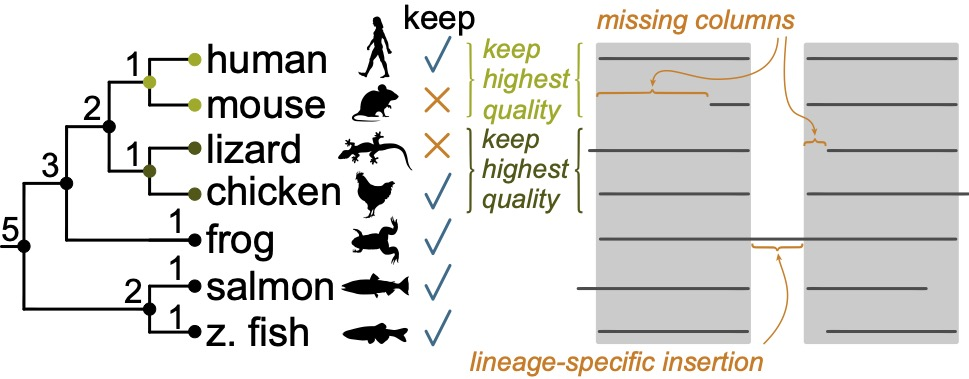
<br>
Topiary redundancy reduction and quality control. This analysis starts with seven sequences (taken from seven organisms) with the goal of retaining five for the downstream analysis. The numbers next to the ancestral nodes on the tree are the budget allocated for all descendants: 5 for all organisms, 2 for the fishes, 3 for tetrapods, etc. The “keep” column indicates which sequences are kept after the redundancy reduction step. A schematic alignment is shown on the right, with poorly aligned and missing regions labeled. The alignment quality is used to select which sequences to keep within taxonomic blocks (human/mouse and lizard/chicken, in this example).
<br> 
<br> 
### Argument definitions and default parameters
----------

+ **df** : *pandas.DataFrame*
<br> Topiary dataframe

+ **seqs_per_column** : *float, default=1*
<br> Aim to have this number of sequences per column in the key species sequences. (For example, if the key sequence is 100 amino acids long,
seqs_per_column=1 would aim for 100 sequences; 2 would aim for 200 sequences).

+ **worst_align_drop_fx** : *float, default=0.1*
<br> After alignment, drop approximately this fraction of the sequences, selecting those that have long insertions and are missing chunks of sequences.

+ **max_seq_number** : *int, default=500*
<br> Maximum number of sequences to get, regardless of seqs_per_column and key sequence length. 

+ **weighted_paralog_split** : *bool, default=False*
<br> When deciding how much of the total budget to assign to each paralog, weight the budget by the number of times each paralog is seen. If False, (default), split the budget as evenly as possible between the paralogs in the dataframe.

+ **merge_block_size** : *int, default=50*
<br> Create blocks of paralogs merge_block_size out of the species tree to do merging based on sequence identity.

+ **redundancy_cutoff** : *float, default=0.98* 
<br> Merge sequences from closely related species with sequence identity above cutoff.

+ **sparse_column_cutoff** : *float, default=0.80*
<br> When checking alignment quality, a column is sparse if it has gaps in more than sparse_column_cutoff sequences.

+ **align_trim** : *tuple, default=(0.05,0.95)*
<br> When checking alignment quality, do not score the first and last parts of the alignment. Interpreted like a slice, but with percentages (0.0,1.0) would not trim; (0.05,0,98) would trim the first 0.05 off the front and the last 0.02 off the back.

+ **paralog_column** : *str, default="recip_paralog"*
<br> Column holding preliminary paralog calls.

+ **species_tree_aware** : *bool, default=True*
<br> If True, merge paying attention to species tree and paralog. If False, merge all sequences based on sequence identity (similar to CD-hit)weighted_paralog_split : bool, default=False when deciding how much of the total budget to assign to each paralog, weight the budget by the number of times each paralog is seen. If False, (default), split the budget as evenly as possible between the paralogs in the dataframe.



+ **target_length** : *int, optional*
<br> Target_length for sequence. Must be specified with + pct_length_cutoff.

+ **pct_length_cutoff** : *float, optional*
<br> If length is within pct_length_cutoff of target_length, give good quality score. Otherwise, bad.


### Returns
----------
**df** : *pandas.DataFrame*
<br> Dataframe with keep set to False for redundant sequences

----------

In [ ]:
#@title Reduce number of sequences.

# Execute this cell to perform redundancy reduction and quality control.

# The following parameters can be manipulated at this step:

input_dataframe = "02_recip-blast-dataframe.csv"  # {type:"string"}
output_dataframe = "03_shrunk-dataframe.csv"      # {type:"string"}

species_tree_aware = True           # {type:"boolean"}
seqs_per_column = 1                 # {type:"number"}
max_seq_number = 500                # {type:"integer"}
redundancy_cutoff = 0.98            # {type:"number"}
worst_align_drop_fx = 0.1           # {type:"number"}
sparse_column_cutoff = 0.80         # {type:"number"}
align_trim_first = 0.05             # {type:"number"}
align_trim_last = 0.95              # {type:"number"}
weighted_paralog_split = False      # {type:"boolean"}
merge_block_size = 50               # {type:"number"}

df = pd.read_csv(input_dataframe)

kwargs = {"df":df,
          "paralog_column":"recip_paralog",
          "species_tree_aware":species_tree_aware,
          "seqs_per_column":seqs_per_column*(1 + worst_align_drop_fx),
          "max_seq_number":max_seq_number*(1 + worst_align_drop_fx),
          "redundancy_cutoff":redundancy_cutoff,
          "sparse_column_cutoff":sparse_column_cutoff,
          "align_trim":(align_trim_first,align_trim_last),
          "weighted_paralog_split":weighted_paralog_split,
          "merge_block_size":merge_block_size}

df = topiary.quality.shrink_dataset(**kwargs)
topiary.write_dataframe(df,output_dataframe)

# 04. Alignment
Topiary uses Muscle5 with its default parameters to generate the MSA (Edgar RC, 2021). We selected this algorithm due to its demonstrated high performance, as well as the extremely fast “super5” algorithm that is useful for generating draft alignments for large datasets. Advanced users can set all Muscle5 options. ***XXX is that going to be written out here? XXX

In [ ]:
#@title Align sequences

# Execute this cell to align the sequences in your reduced dataframe.

input_dataframe = "03_shrunk-dataframe.csv"   # {type:"string"}
output_dataframe = "04_aligned-dataframe.csv" # {type:"string"}

df = pd.read_csv(input_dataframe)

df = topiary.muscle.align(df)
topiary.write_dataframe(df,output_dataframe)

# 05. Polish alignment and re-align

Polish a near-final alignment by removing sequences that have long insertions or are missing large chunks of the sequence.

Calculate alignment quality scores for each sequence in the dataframe. The
resulting scores are loaded as columns into the dataframe. In all cases, a
higher score is a worse alignment.

The three calculated scores are:

+ `fx_in_sparse`: fraction of columns from the sequence that have no
  gap where most other sequences have a gap.
+ `fx_missing_dense`: fraction of columns from the sequence that have
  a gap where most other sequences have no gap.
+ `sparse_run_length`: length of longest insertion in the sequence.
  The insertion does not have to be continuous in sequence. Instead, this
  function finds runs of sparse_columns and then counts how many columns
  within each run come from this sequence. If, for example, there are ten
  sparse columns in a row and a sequence has eight non-gap characters
  over that run of sparse columns, the run length would be eight.

Briefly: columns are characterized as either dense (most sequences have a non-gap) or sparse (defined as not dense). This call is made using the sparse_column_cutoff argument. This function then identifies sequences that have many non-gap characters in sparse columns overall, sequences with runs of non-gap characters in long runs of sparse columns, and sequences that are missing large portions of the dense columns. It drops sequences that have BOTH large fx_sparse AND large sparse_run. It also drops sequences that have BOTH large fx_missing AND are flagged as partial in the original NCBI entry.

Note: If avg_bin_contents is specified, use a coarse-grained histogram approach
to percentile calculation. This tends to be conservative. If a large number
of values are in a bin with a high value, the function will end up grabbing
the cutoff corresponding to the first sparsely populated bin, even if this
means selecting fewer sequences than would strictly correspond to the top
pct percentile.

### Arguments definitions and default parameters used in this step:

+ **df** : *pandas.DataFrame* 
<br> Topiary dataframe
+ **realign** : *bool, default=True*
<br> Re-align the MSA after dropping columns if set to True.
+ **sparse_column_cutoff** : *float, default=0.80*
<br> When checking alignment quality, a column is sparse if it has gaps in more than <sparse_column_cutoff> sequences.

+ **align_trim** : *tuple, default=(0.1,0.9)*
<br> When checking alignment quality, do not score the first and last parts of the alignment. Interpreted like a slice, but with percentages. (0.0,1.0) would not trim; (0.05,0,98) would trim the first 0.05 off the front and the last 0.02 off the back. The default to this function does not trim at all.

+ **fx_sparse_percentile** : *float, default=0.90*
<br> Flag any sequence that is has a fraction sparse above this percentile cutoff.

+ **sparse_run_percentile** : *float, default=0.90*
<br> Flag any sequence that is has total sparse run length above this percentile cutoff.

+ **fx_missing_percentile** : *float, default=0.90*
<br> flag any sequence that is has a fraction missing above this percentile cutoff.

In [ ]:
#@title Polish alignment and re-align.

# Execute this cell to polish alignment and re-align polished set of sequences.

# The following parameters can be manipulated at this step:

out_dir = "alignment"                         # {type:"string"}
input_dataframe = "04_aligned-dataframe.csv"  # {type:"string"}
output_dataframe_polished_alignment = "05_clean-aligned-dataframe.csv" # {type:"string"}
output_fasta_file = "06_alignment.fasta"      # {type:"string"}

realign = True                # {type:"boolean"}
sparse_column_cutoff = 0.80   # {type:"number"}
align_trim_first = 0.1        # {type:"number"}
align_trim_last = 0.9         # {type:"number"}
fx_sparse_percentile = 0.90   # {type:"number"}
sparse_run_percentile = 0.90  # {type:"number"}
fx_missing_percentile = 0.90  # {type:"number"}

df = pd.read_csv(input_dataframe)

kwargs = {"df":df,
          "realign":realign,
          "sparse_column_cutoff":sparse_column_cutoff,
          "align_trim":(align_trim_first,align_trim_last),
          "fx_sparse_percentile":fx_sparse_percentile,
          "sparse_run_percentile":sparse_run_percentile,
          "fx_missing_percentile":fx_missing_percentile}

df = topiary.quality.polish_alignment(**kwargs)
topiary.write_dataframe(df,output_dataframe_polished_alignment)
topiary.write_fasta(df,
                    out_file=output_fasta_file,
                    seq_column="alignment",
                    label_columns=["species","recip_paralog"])


# 06. Inspect and edit alignment

Before reconstructing a phylogenetic tree and ancestors, we strongly recommend inspecting and possibly editing the alignment. 

Download the 06_alignment.fasta file onto your computer. To do this, click on the folder icon on the Colab menu on the left side of the window. Navigate into the seed-to-ali folder (or the name you gave your output directory in the previous step), hover over "06_alignment.fasta", click on the three dots to the right and choose "Download."

There are a variety of pieces of software for visualizing alignments, including AliView (Larsson A, 2014), JALView (Waterhouse AM, 2009), and MEGA (Tamura K, 2021). We generally use AliView because of its balance of utility and simplicity.
There are differing views on whether to manually edit an alignment (Catanach TA, 2019; Morrison DA, 2006); the topiary package allows a user to manually edit their alignment but does not require it. We generally recommend making a few adjustments to alignments. Importantly, if we edit an alignment, we publish the alignment as supplemental material in the resulting manuscript so others can reproduce our work. We use the four “moves” listed below (see the [documentation](https://topiary-asr.readthedocs.io/en/latest/) for detailed instructions and examples).

1. Trim variable-length N- and C-terminal regions from the alignment. A huge number of sparse and variable columns will slow evolutionary analyses and will generally not provide enough signal to be reconstructed with confidence.
2. Delete sequences with long, unique insertions or deletions (indels). Indels can lead to alignment ambiguity around flanking regions. Further, they provide no information for most ancestors, most of whom do not have the indel, while increasing the computational cost of the phylogenetic analysis. Note, we do not make internal edits to sequences (say, by deleting a long lineage-specific insertion) as this becomes difficult to track or justify upon future realignment steps.
3. Delete lineage-specific duplicates, selecting the sequence with the greatest sequence coverage. The pipeline generally does a good job of deleting sequences in this class; however, if such sequences slip through, we delete them from the alignment.
Because trying to align long, unique, and variable sequences can affect the alignment of other sequences, we generally use Muscle5 to re-align the full MSA after we perform steps 1-3. This can be done directly from AliView. (We will often iterate through steps 1-3 and full alignment several times.)
4. Finally, after we are satisfied that we have sequences of reasonable length and composition, we carefully inspect the alignment and may correct “obvious” local misalignments. In our view, these edits makes the alignment a more accurate description of sequence homology than otherwise; however, we recognize that this is subjective and difficult to quantify. As noted above, we publish our alignment with our final ancestors to allow others to assess our judgement and promote reproducibility.

## Read the edited alignment back into the topiary dataframe
If you made edits to the alignment, it needs to be read back into the topiary dataframe in order to move onto the next step. You can do this with the command line script *topiary-read-fasta-into*. If you closed this notebook to edit your alignment or are not running the notebook in order, you must designate the topiary spreadsheet (alignment.csv output from the previous cell or 05_clean-aligned-dataframe.csv saved in your designated Google Drive working directory) that corresponds to the edited alignment.fasta file you are about to upload. If Colab cannot read your file, try re-initializing the notebook to reset your working directory. 

In [ ]:
#@title Load the topiary dataframe

#@markdown *If you are running this notebook straight through, skip this cell.*

#@markdown Before running this cell, specify either: 
#@markdown + A file containing an aligned dataframe in your working directory 
#@markdown (example: seed-to-ali/05_clean-aligned-dataframe.csv). 
#@markdown + Select `upload_file` to upload a file directly from your computer. 

aligned_dataframe = "05_clean-aligned-dataframe.csv"  #@param {type: "string"}
upload_file = False                                   #@param {type: "boolean"}

if issubclass(type(aligned_dataframe),str):
    aligned_dataframe = aligned_dataframe.strip()

if aligned_dataframe != "" and upload_file:
    err = "Please give an alignment OR select upload file\n"
    raise ValueError(err)
  
if aligned_dataframe == "" and not upload_file:
    err = "Please either give an alignment or select upload file\n"
    raise ValueError(err)

if upload_file:

    try:
        from google.colab import files
        uploaded_files = files.upload()
        keys = list(uploaded_files.keys())
        aligned_dataframe = keys[0] #uploaded_files[keys[0]]
    except ImportError:
        pass
    
try:
    df = pd.read_csv(aligned_dataframe)

except:
    err = f"Could not read {aligned_dataframe}. This should be a .fasta file. Try re-initializing the Colab environment.\n"
    raise ValueError(err)

In [ ]:
#@title Read the alignment back into the topiary dataframe

#@markdown Before running this cell, specify either: 
#@markdown + A fasta file containing an alignment in your working directory 
#@markdown (example: "seed-to-ali/07_edited-alignment.fasta). 
#@markdown + Select `upload_file` to upload a file directly from your computer. 

uploaded_fasta_file = "07_edited_alignment.fasta" #@param {type: "string"}
upload_file = False                               #@param {type:"boolean"}

#@markdown Your new topiary dataframe will be saved as "08_final-dataframe.csv"

if issubclass(type(uploaded_fasta_file),str):
    uploaded_fasta_file = uploaded_fasta_file.strip()

if uploaded_fasta_file != "" and upload_file:
    err = "Please give an alignment OR select upload file\n"
    raise ValueError(err)
  
if uploaded_fasta_file == "" and not upload_file:
    err = "Please either give an alignment or select upload file\n"
    raise ValueError(err)

if upload_file:

    try:
        from google.colab import files
        uploaded_files = files.upload()
        keys = list(uploaded_files.keys())
        uploaded_fasta_file = keys[0] #uploaded_files[keys[0]]
    except ImportError:
        pass
    
try:
    alignment_df = topiary.read_fasta_into(df,uploaded_fasta_file)

except:
    err = f"Could not read {uploaded_fasta_file}. This should be a .fasta file\n"
    raise ValueError(err)

alignment_df

# Sections that still need to be added
Code to view what you did?

Example outputs

# Example: Toy dataset walk-through

In [ ]:
import topiary
import numpy as np
import pandas as pd 

### EVERYTHING AFTER THIS LINE IS IS USED TO SET UP TOPIARY IN A GOOGLE
### COLAB ENVIRONMENT. IF RUNNING THIS NOTEBOOK LOCALLY, THE LINES BELOW
### IN THIS CELL MAY BE SAFELY DELETED. 

#@title Re-initialize environment 

#@markdown Execute this cell to re-initialize the environment before continuing
#@markdown onto the example.

#@markdown Select a working directory to save these example outputs on Google Drive.
google_drive_directory = "" #@param {type:"string"}

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:

    import os
    os.chdir("/content/")

    topiary._in_notebook = "colab"
    import colab_installer
    colab_installer.initialize_environment()
    colab_installer.mount_google_drive(google_drive_directory)

In [ ]:
#@title Example 00. Load example seed dataset into topiary dataframe

# Execute this cell to load a toy seed dataset provided with the 
# topiary package. If you did not designate a Google Drive directory
# to save these example calculations in, remove "../../../" from the 
# file path below.

seed_dataset = "../../../software/topiary/tests/data/seed-dataframes/good-seed-df.csv" # {type:"string"}

# Local users, use the following path instead:
# seed_dataset = "../data/example_seed.csv" XX

df = pd.read_csv(seed_dataset)

In [ ]:
#@title Example 01. Initial dataframe construction

# Execute this cell to build the initial dataset of similar BLAST hits.

# The following parameters can be manipulated:

output_dataframe = "01_example_initial-dataframe.csv" # {type:"string"}

#ncbi_blast_db = None         # {type:"string"}
local_blast_db = None         # {type:"string"}
blast_xml = None              # {type:"string"}
move_mrca_up_by = 0           # {type:"positive integer"}
hitlist_size = 50             # {type:"integer"}
e_value_cutoff = 0.001        # {type:"number"}
gapcost_gap_exists = 11       # {type:"integer"}
gapcost_per_residue = 1       # {type:"integer"}
num_ncbi_blast_threads = 1    # {type:"integer"}
num_local_blast_threads = -1  # {type:"integer"}
keep_blast_xml = True         # {type:"boolean"}
#overwrite = True             # {type: "boolean"}

kwargs = {"seed_df":df,
          #"ncbi_blast_db":ncbi_blast_db,
          "local_blast_db":local_blast_db,
          "blast_xml":blast_xml,
          "move_mrca_up_by":0,
          "hitlist_size":10,
          "e_value_cutoff":e_value_cutoff,
          "gapcosts":(gapcost_gap_exists,gapcost_per_residue),
          "num_ncbi_blast_threads":num_ncbi_blast_threads,
          "num_local_blast_threads":num_local_blast_threads,
          "keep_blast_xml":keep_blast_xml}

df, key_species, paralog_patterns, species_aware = topiary.df_from_seed(**kwargs)
topiary.write_dataframe(df,output_dataframe)

In [ ]:
#@title Example 02. Identify each hit by reciprocal BLAST

# Run this code block to perform reciprocal BLAST.

# The following parameters can be manipulated at this step:

input_dataframe = "01_example_initial-dataframe.csv"      # {type:"string"}
output_dataframe = "02_example_recip-blast-dataframe.csv" # {type:"string"}

#ncbi_blast_db = None         # {type:"string"}
local_recip_blast_db = None   # {type:"string"}
num_local_blast_threads = -1  # {type:"integer"}
keep_recip_blast_xml = False  # {type:"boolean"}

df = pd.read_csv(input_dataframe)

df = topiary.recip_blast(df,
                        paralog_patterns=paralog_patterns,
                        #ncbi_blast_db=ncbi_blast_db,
                        local_blast_db=local_recip_blast_db,
                        num_threads=num_local_blast_threads,
                        keep_blast_xml=keep_recip_blast_xml)

topiary.write_dataframe(df,output_dataframe)

In [ ]:
#@title Example 03. Redundancy reduction, quality control, and alignment

# Execute this cell to perform redundancy reduction and quality control.

# The following parameters can be manipulated at this step:

input_dataframe = "02_example_recip-blast-dataframe.csv"  # {type:"string"}
output_dataframe = "03_example_shrunk-dataframe.csv"      # {type:"string"}


species_tree_aware = True       # {type:"boolean"}
seqs_per_column = 1             # {type:"number"}
max_seq_number = 10             # {type:"integer"}
redundancy_cutoff = 0.98        # {type:"number"}
worst_align_drop_fx = 0.1       # {type:"number"}
sparse_column_cutoff = 0.80     # {type:"number"}
align_trim_first = 0            # {type:"number"}
align_trim_last = 1             # {type:"number"}
weighted_paralog_split = False  # {type:"boolean"}
merge_block_size = 50           # {type:"number"}

df = pd.read_csv(input_dataframe)

kwargs = {"df":df,
          "paralog_column":"recip_paralog",
          "species_tree_aware":species_tree_aware,
          "seqs_per_column":seqs_per_column*(1 + worst_align_drop_fx),
          "max_seq_number":max_seq_number*(1 + worst_align_drop_fx),
          "redundancy_cutoff":redundancy_cutoff,
          "sparse_column_cutoff":sparse_column_cutoff,
          "align_trim":(align_trim_first,align_trim_last),
          "weighted_paralog_split":weighted_paralog_split,
          "merge_block_size":merge_block_size}

df = topiary.quality.shrink_dataset(**kwargs)
topiary.write_dataframe(df,output_dataframe)

In [ ]:
#@title Example 04. Align sequences

# Execute this cell to align the sequences in your reduced dataframe.

input_dataframe = "03_example_shrunk-dataframe.csv"   # {type:"string"}
output_dataframe = "04_example_aligned-dataframe.csv" # {type:"string"}

df = pd.read_csv(input_dataframe)

df = topiary.muscle.align(df)
topiary.write_dataframe(df,output_dataframe)

In [ ]:
#@title Example 05. Polish alignment and re-align.

# Execute this cell to polish alignment and re-align polished set of sequences.

# The following parameters can be manipulated at this step:

out_dir = "example_alignment"                         # {type:"string"}
input_dataframe = "04_example_aligned-dataframe.csv"  # {type:"string"}
output_dataframe_polished_alignment = "05_example_clean-aligned-dataframe.csv" # {type:"string"}
output_fasta_file = "06_example_alignment.fasta"      # {type:"string"}

realign = True                # {type:"boolean"}
sparse_column_cutoff = 0.80   # {type:"number"}
align_trim_first = 0.1        # {type:"number"}
align_trim_last = 0.9         # {type:"number"}
fx_sparse_percentile = 0.90   # {type:"number"}
sparse_run_percentile = 0.90  # {type:"number"}
fx_missing_percentile = 0.90  # {type:"number"}

df = pd.read_csv(input_dataframe)

kwargs = {"df":df,
          "realign":realign,
          "sparse_column_cutoff":sparse_column_cutoff,
          "align_trim":(align_trim_first,align_trim_last),
          "fx_sparse_percentile":fx_sparse_percentile,
          "sparse_run_percentile":sparse_run_percentile,
          "fx_missing_percentile":fx_missing_percentile}

df = topiary.quality.polish_alignment(**kwargs)
topiary.write_dataframe(df,output_dataframe_polished_alignment)
topiary.write_fasta(df,
                    out_file=output_fasta_file,
                    seq_column="alignment",
                    label_columns=["species","recip_paralog"])

pretty_name = os.path.join(out_dir,output_dataframe_polished_alignment)

### Example 06. Inspect and edit alignment
